In [ ]:
# GET POR Files Already Downloaded
import glob
import shutil

source = '/Users/kris/Downloads/FFIEC/'
destination = '/Users/kris/Library/CloudStorage/OneDrive-Personal/Documents/Visual Studio 2019/Repos/ffiec-xbrl/PubData/Src/RSSDs/'

for src in glob.glob(source + '*/* POR *'):
    shutil.copy(src, destination)

In [1]:
# Imports and Constants
import pandas as pd
import numpy as np

from FDIC import ExEngine
from FDIC import constants as paths
from FDIC.ETL import ETL
from FDIC.RateLimiter import RateLimiter 

#dtypes = {'RSSD_ID':str,
#          'FDIC_Certificate_Number':str,
#          'OCC_Charter_Number':str,
#          'OTS_Docket_Number':str,
#          'Primary_ABA_Routing_Number':str,
#          'Financial_Institution_Name': str,
#          'Financial_Institution_Address': str,
#          'Financial_Institution_City': str,
#          'Financial_Institution_State': str,
#          'Financial_Institution_Zip_Code': str,
#          'Financial_Institution_Filing_Type': str,
#          'Last Date/Time Submission Updated On': 'str'}

dtypes = {'IDRSSD': np.dtype('str'),
          'FDIC Certificate Number': np.dtype('str'),
          'OCC Charter Number': np.dtype('str'),
          'OTS Docket Number': np.dtype('str'),
          'Primary ABA Routing Number': np.dtype('str'),
          'Financial Institution Name': np.dtype('str'),
          'Financial Institution Address': np.dtype('str'),
          'Financial Institution City': np.dtype('str'),
          'Financial Institution State': np.dtype('str'),
          'Financial Institution Zip Code': np.dtype('str'),
          'Financial Institution Filing Type': np.dtype('str'),
          'Last Date/Time Submission Updated On': np.dtype('str')}

filepath_in = 'PubData/Src/RSSDs/'
filepath_out = 'PubData/'
filename = 'FFIEC CDR Call Bulk POR 03312024.txt'

In [2]:
# Compare Bank_Dim and RSSD_Dict
df_bank = pd.read_csv(filepath_out + 'Bank_Dim.csv', sep=',', index_col=False, quotechar='"')
df_rssd = pd.read_csv(filepath_out + 'RSSD_Dict.csv', sep=',', index_col=False, quotechar='"')

print(df_bank.shape, df_rssd.shape)


(4623, 8) (4623, 12)


In [3]:
#Open File (Bank_dim from RSSD_Por)

#with open(filename, 'r') as file:
df = pd.read_csv(filepath_in + filename, sep='\t', index_col=False, quotechar='"', dtype = dtypes, parse_dates=['Last Date/Time Submission Updated On'])

In [4]:
#Clean RSSD_Por File
df = df.apply(lambda x: x.str.strip() if x.dtype.name == 'object' else x, axis=0)

In [5]:
#Clean RSSD_Por Format - Align with and Create RSSD_Dict.csv
df.rename(columns={'IDRSSD': 'RSSD_ID'}, inplace=True)
df.columns = df.columns.str.replace(' ', '_')

#Create RSSD_Dict file
#df.iloc[:25].to_csv(filepath_out + 'RSSD_Dict.csv', sep=',', quotechar='"', index= False,)
df.to_csv(filepath_out + 'RSSD_Dict.csv', sep=',', quotechar='"', index= False)

In [ ]:
#Confirm data
df[:5]

#df.Financial_Institution_Address
df.iloc[0,6]

In [7]:

rate_limiter = RateLimiter(max_calls=2450, period_in_seconds=3660) #~2.4k every 60min
etl = ETL(paths.WSDL_path, rate_limiter)
#ExEngine.FillMaster('504713')
#etl.GenBankDim()
etl.DownloadCallReports(['XBRL'])

#etl.GenBankMaster()
#etl.GenCallMaster()

Already downloaded: BANK OF HANCOCK COUNTY_37
Already downloaded: FIRST COMMUNITY BANK XENIAFLORA_242
Already downloaded: BROADSTREET BANK SSB_279
Already downloaded: BISON STATE BANK_354
Already downloaded: LOWRY STATE BANK_457
Already downloaded: BALLSTON SPA NATIONAL BANK_505
Already downloaded: RVR BANK_1155
Already downloaded: BANK OF GRANDIN_1351
Already downloaded: HILLTOP NATIONAL BANK_1454
Already downloaded: LIBERTY NATIONAL BANK IN PARIS THE_1669
Already downloaded: WASHITA STATE BANK_1856
Already downloaded: LAMAR NATIONAL BANK_2161
Already downloaded: ALBANY BANK  TRUST CO NATIONAL ASSOCIATION_2732
Already downloaded: GENOA COMMUNITY BANK_2750
Already downloaded: FIRST NATIONAL BANK OF GORDON THE_3252
Already downloaded: FARMBANK_3458
Already downloaded: BANK OF CLARENDON THE_3720
Already downloaded: MIDCOUNTRY BANK_3971
Already downloaded: KANZA BANK_4156
Already downloaded: FARMERS AND MERCHANTS BANK_4231
Already downloaded: FIRST CREDIT BANK_5069
Already downloaded: FIR

KeyboardInterrupt: 

In [ ]:
call_report_path = '/Users/kris/data_sources/fdic/BulkReports/ACNB BANK_5210/ACNB BANK_5210_20010331.XBRL'
bank_path = '/Users/kris/data_sources/fdic/BulkReports/ACNB BANK_5210/'
folder_path = '/Users/kris/data_sources/fdic/BulkReports/'

#tot = etl.ParseXBRL(call_report_path)
etl.GenBankMaster()
#etl.GenCallMaster()

In [ ]:
etl.GenCallMaster()

In [ ]:
path = paths.localPath + paths.filename_MasterCall
df = etl.loadCSV(path)

In [8]:
path = '/Users/kris/data_sources/fdic/BulkReports/'
df = etl.createDF_from_CSV(path_root =path)
df

Loading DF from CSVs:
	Dataframe loaded with 566 institutions processed


In [ ]:
df.head(1)

In [ ]:
#Number of RSSD's by Period, by RSSD_ID, by MDRM_Item
g_df = df[df['RSSD_ID']==28013].groupby(['MDRM_Item', 'RSSD_ID', 'ReportPeriodEndDate'])['MDRM_Item'].count()
g_df

In [ ]:
#Field count by date (RSSD report count)
pvt = df[['MDRM_Item', 'ReportPeriodEndDate']].pivot_table(
    index=['MDRM_Item'],
    columns=['ReportPeriodEndDate'],
    values=['MDRM_Item'],
    aggfunc={'MDRM_Item': ['count']}
)
pvt.fillna(0, inplace=True)
pvt

#Filter out either rows or columns with only no reporting (only zeros)
#filtered_pvt = pvt.loc[(pvt > 0).any(axis=1),:]
filtered_pvt = pvt.loc[:, (pvt > 0).any(axis=0)]
filtered_pvt

In [ ]:
#Number of filers (RSSD's) by date
pvt = df[['ReportPeriodEndDate', 'RSSD_ID']].drop_duplicates().reset_index().pivot_table(
    index=['ReportPeriodEndDate'],
    values=['RSSD_ID'],
    aggfunc={'RSSD_ID': ['count']}
).sort_values(by='ReportPeriodEndDate', ascending=False)

pvt = pvt.set_axis([col for col in pvt.keys()], axis=1)
#pvt.reset_index(inplace=True)

pvt.fillna(0, inplace=True)
pvt

In [9]:
filepath = 'PubData/MDRM_Dict.csv'
mdrm = etl.loadCSV(path = filepath)
mdrm

,MDRM_Item,Start_Date,End_Date,Item_Name,Confidential,Reporting_Forms
0,RCOA3792,2014-03-31,9999-12-31,TOTAL QUALIFYING CAPITAL ALLOWABLE UNDER THE R...,No,FFIEC 041
1,RCOA5310,2014-03-31,9999-12-31,GENERAL LOAN AND LEASE VALUATION ALLOWANCES,No,FFIEC 041
2,RCOA5311,2014-03-31,9999-12-31,TIER 2 (SUPPLEMENTARY) CAPITAL,No,FFIEC 041
3,RCOA7204,2014-03-31,9999-12-31,TIER 1 LEVERAGE CAPITAL RATIO,No,FFIEC 041
4,RCOA7205,2014-03-31,9999-12-31,TOTAL RISK-BASED CAPITAL RATIO,No,FFIEC 041
...,...,...,...,...,...,...
5817,RCONS619,2015-03-31,9999-12-31,NOTIONAL PRINCIPAL AMOUNTS OF CENTRALLY CLEARE...,No,FFIEC 041
5818,RCONS620,2015-03-31,9999-12-31,NOTIONAL PRINCIPAL AMOUNTS OF CENTRALLY CLEARE...,No,FFIEC 041
5819,RCONS621,2015-03-31,9999-12-31,NOTIONAL PRINCIPAL AMOUNTS OF CENTRALLY CLEARE...,No,FFIEC 041
5820,RCONS622,2015-03-31,9999-12-31,NOTIONAL PRINCIPAL AMOUNTS OF CENTRALLY CLEARE...,No,FFIEC 041


In [25]:
mdrm[mdrm['Item_Name'].str.contains('TOTAL ASSETS')]
mdrm[mdrm['Item_Name'] == 'TOTAL ASSETS ']
#mdrm.iloc[1196]

,MDRM_Item,Start_Date,End_Date,Item_Name,Confidential,Reporting_Forms
1196,RSSD2170,1992-06-30,1997-01-16,TOTAL ASSETS,No,NaN
2148,RCF02170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2149,RCF12170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2150,RCF22170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2151,RCF32170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2152,RCF42170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2153,RCF52170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2154,RCF62170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2155,RCF72170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b
2156,RCF82170,1990-03-31,9999-12-31,TOTAL ASSETS,Yes,FR 2886b


In [28]:
df[df['MDRM_Item']=='RCON2170']

,ReportPeriodEndDate,RSSD_ID,Item_Name,MDRM_Item,Confidential,Value
161,2019-06-30,117775,TOTAL ASSETS,RCON2170,No,98034000
1606,2018-06-30,117775,TOTAL ASSETS,RCON2170,No,96330000
3025,2021-12-31,117775,TOTAL ASSETS,RCON2170,No,112687000
4106,2020-12-31,117775,TOTAL ASSETS,RCON2170,No,112345000
5130,2010-09-30,117775,TOTAL ASSETS,RCON2170,No,87610000
...,...,...,...,...,...,...
97790,2022-06-30,44750,TOTAL ASSETS,RCON2170,No,172871000
98501,2012-03-31,44750,TOTAL ASSETS,RCON2170,No,176593000
99877,2014-09-30,44750,TOTAL ASSETS,RCON2170,No,164451000
101257,2013-03-31,44750,TOTAL ASSETS,RCON2170,No,173911000


In [81]:
##Find rows that don't have INT values in Value column
df.dtypes

invalid_rows = df[df['Value'].apply(lambda x: isinstance(x, str) and not x.replace('.', '', 1).isdigit())]
invalid_rows

,ReportPeriodEndDate,RSSD_ID,Item_Name,MDRM_Item,Confidential,Value
330,2019-06-30,117775,AGRICULTURAL LOANS TO SMALL FARMS INDICATOR,RCON6860,True,false
331,2019-06-30,117775,NO COMMENT ON THE BANK MANAGEMENT STATEMENT,RCON6979,True,false
332,2019-06-30,117775,LOANS TO SMALL BUSINESSES INDICATOR,RCON6999,True,false
394,2019-06-30,117775,FIDUCIARY POWERS GRANTED BUT NOT EXERCISED,RCONA345,True,false
395,2019-06-30,117775,FIDUCIARY POWERS GRANTED AND EXERCISED BUT NO ...,RCONA346,True,false
...,...,...,...,...,...,...
104160,2015-09-30,44750,FIRST ITEMIZED AMOUNT THAT EXCEEDS 10% OF ALL ...,TEXT4461,True,Income on BOLI
104163,2015-09-30,44750,FIRST ITEMIZED AMOUNT THAT EXCEEDS 10% OF OTHE...,TEXT4464,True,Insurance and Bonds
104164,2015-09-30,44750,SECOND ITEMIZED AMOUNT THAT EXCEEDS 10% OF OTH...,TEXT4467,True,Provision for Income Taxes
104165,2015-09-30,44750,THIRD ITEMIZED AMOUNT THAT EXCEEDS 10% OF OTHE...,TEXT4468,True,ORE Expense


In [55]:
##Format dtypes of dataframe
df = df.astype({
    'ReportPeriodEndDate': 'datetime64[ns]',
    'Item_Name': 'str',
    'MDRM_Item': 'str',
    'Confidential': 'bool'
    #'Value': 'float'
    })

In [118]:
## Print analytics from dataframe

#Filter df by Item and Confidential status
#filtered_df = df[(df['MDRM_Item']=='RCON2170') & (df['Confidential']=='No')].astype({'Value': int})
filtered_df = df[(df['MDRM_Item']=='RCON2170')].astype({'Value': int})

totals = filtered_df.groupby(by='ReportPeriodEndDate')['Value'].sum().astype(int)
totals

counts = filtered_df.groupby(by='ReportPeriodEndDate')['Value'].count().astype(int)
counts

pctChgs = totals.pct_change()
pctChgs

res = pd.DataFrame({'Values':totals, 'pctChgs':pctChgs, 'Counts':counts})
res.index = res.index.strftime('%Y-%m-%d')
res.style.format({
    'Values': '{:,}',
    'pctChgs': lambda x: '{:.2%}'.format(x) if pd.notna(x) else x,
    'Counts': '{:,}'
})


,Values,pctChgs,Counts
ReportPeriodEndDate,,,
2001-03-31,"117,479,352,000",nan,495
2001-06-30,"119,247,073,000",1.50%,495
2001-09-30,"120,175,512,000",0.78%,495
2001-12-31,"125,572,732,000",4.49%,495
2002-03-31,"123,633,826,000",-1.54%,495
2002-06-30,"124,700,126,000",0.86%,495
2002-09-30,"131,109,435,000",5.14%,495
2002-12-31,"137,948,801,000",5.22%,495
2003-03-31,"134,480,337,000",-2.51%,495


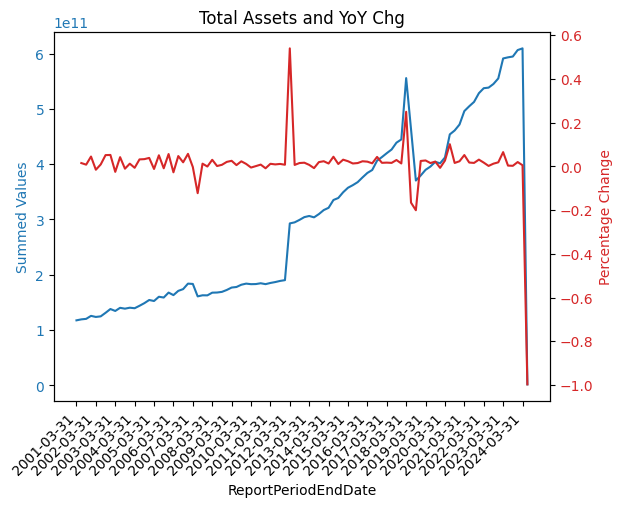

In [129]:
from matplotlib import pyplot as plt

# Plotting
fig, ax1 = plt.subplots()

# Plot summed values
color = 'tab:blue'
ax1.set_xlabel('ReportPeriodEndDate')
ax1.set_ylabel('Summed Values', color=color)
ax1.plot(res.index, res['Values'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for percentage change
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Percentage Change', color=color)
ax2.plot(res.index, res['pctChgs'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Format the x-axis dates
#fig.autofmt_xdate()

# Set x-axis major ticks to show at regular intervals
interval = 4
ax1.set_xticks(res.index[::interval])

# Rotate the x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Add a title
plt.title('Total Assets and YoY Chg')

# Show the plot
plt.show()



In [77]:
#filtered_df = df[(df['ReportPeriodEndDate']=='2001-03-31') & (df['MDRM_Item']=='RCON2170')]
filtered_df = df[(df['RSSD_ID']=='140362') & (df['MDRM_Item']=='RCON2170') & (df['Confidential']==False)]
filtered_df

,ReportPeriodEndDate,RSSD_ID,Item_Name,MDRM_Item,Confidential,Value
